Допустим, вы ввели три фичи:  

1.Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (по время surge)  
Ожидаем: выше price-to-order конверсия во время surge  
2.Если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены  
Ожидаем: ниже отмены на Android устройствах  
3.При уточнении, уверен ли юзер в отмене заказа не из центра, добавить эмодзи котика, просящего не отменять  
Ожидаем: ниже отмены по заказам НЕ из центра  
    
Используя новые данные, постройте следующие графики для А/Б теста по любой из трех фичей выше (!сплит уже произведен!):  
  - Кумулятивного p-value (разбейте общее количество наблюдений на 7 участков)  
  - Периодического p-value (по дням)  
На основе графиков сделайте вывод о значимости результатов

In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('post_abtest_data.csv')
df

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control
...,...,...,...,...,...,...,...,...,...,...,...
101495,777065,2020-05-25,1,Control,1,0,no surge,Android,NaN,NaN,Control
101496,340213,2020-05-28,1,Control,1,1,no surge,iOS,0.0,1.0,Control
101497,352605,2020-05-26,1,Test,1,1,no surge,Android,0.0,1.0,Test
101498,216082,2020-05-26,1,Control,1,0,surge,Android,NaN,NaN,Control


In [3]:
df.describe()

,user_id,app_opened,price_seen,order_made,user_cancelled,city_center_order
count,101500.000000,101500.0,101500.000000,101500.000000,70157.000000,70157.000000
mean,549874.802207,1.0,0.909931,0.691202,0.142994,0.436991
std,258600.104176,0.0,0.286282,0.462000,0.350069,0.496018
min,100093.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,328223.000000,1.0,1.000000,0.000000,0.000000,0.000000
50%,548827.000000,1.0,1.000000,1.000000,0.000000,0.000000
75%,773051.000000,1.0,1.000000,1.000000,0.000000,1.000000
max,999978.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [4]:
df['group'].unique()

array(['Control', 'Test'], dtype=object)

In [5]:
df['groups'].unique()

array(['Control', 'Test'], dtype=object)

**Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (по время surge)**

отфильтруем только заказы во время surge и разделим данные 2 датафрейма: контрольную и тестовую

In [6]:
df_surge_control = df[(df['group'] == 'Control') & (df['surge'] == 'surge')]
len(df_surge_control)

14383

In [7]:
df_surge_test = df[(df['group'] == 'Test') & (df['surge'] == 'surge')]
len(df_surge_control)

14383

In [ ]:
используем тест Манна-Уитни, т.к. выборка имеет распределение Бернули.

In [8]:
result_mw = mannwhitneyu(df_surge_control['order_made'], df_surge_test['order_made'])
alpha = 0.05
if result_mw.pvalue < alpha and result_mw.statistic > 0:
    print(f'конверсия различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')
else:
    print(f'конверсия не различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')

конверсия различается. statistic - 101469180.0 pvalue - 0.00085


In [ ]:
В целом, конверсия отличается у 2-х групп, и statistic показывает, что в тестовой группе конверсия выше.

Используя новые данные, постройте следующие графики для А/Б теста по любой из трех фичей выше (!сплит уже произведен!):

Кумулятивного p-value (разбейте общее количество наблюдений на 7 участков)  
Периодического p-value (по дням)

**Кумулятивного p-value (разбейте общее количество наблюдений на 7 участков)**

In [9]:
df_sum_control = pd.DataFrame() # добавление данных в накопительный дф
df_sum_test = pd.DataFrame()    # добавление данных в накопительный дф
i = 0 # счетчик
pvalue_per_day = [] # пустой список для накопления p_value
while i < 7:
    df_sample_control = df_surge_control.sample(n=3000, random_state=1)
    df_sample_test = df_surge_test.sample(n=3000, random_state=1)
    df_sum_control = pd.concat([df_sum_control, df_sample_control])
    df_sum_test = pd.concat([df_sum_test, df_sample_test])
    # тест
    result_mw = mannwhitneyu(df_sum_control['order_made'], df_sum_test['order_made'])
    alpha = 0.05
    # добавление pvalue в список и преобразование в датафрейм
    pvalue_per_day.append(result_mw.pvalue)
    pd_pvalue_per_day = pd.DataFrame(pvalue_per_day, columns=['p_value'])
    
    i += 1
    if result_mw.pvalue < alpha and result_mw.statistic > 0:
        print(f'конверсия различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')
    else:
        print(f'конверсия не различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')
    print(len(df_sum_control))

конверсия не различается. statistic - 4408500.0 pvalue - 0.0537
3000
конверсия различается. statistic - 17634000.0 pvalue - 0.01139
6000
конверсия различается. statistic - 39676500.0 pvalue - 0.00265
9000
конверсия различается. statistic - 70536000.0 pvalue - 0.00064
12000
конверсия различается. statistic - 110212500.0 pvalue - 0.00016
15000
конверсия различается. statistic - 158706000.0 pvalue - 4e-05
18000
конверсия различается. statistic - 216016500.0 pvalue - 1e-05
21000


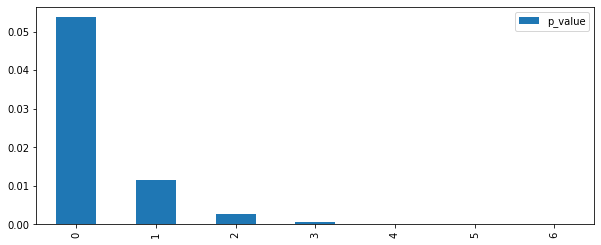

In [10]:
pd_pvalue_per_day.plot.bar(figsize=(10, 4))

In [ ]:
В ходе проведения теста, по мере роста выборки, отличние 2-х групп увеличивается, т.е. конверсия растет.

**Периодического p-value (по дням)**

In [11]:
dates = df['date'].unique()
dates

array(['2020-05-28', '2020-05-29', '2020-05-25', '2020-05-31',
       '2020-05-30', '2020-05-27', '2020-05-26'], dtype=object)

In [12]:
conv_per_day = []
conv_dates = []

for date in dates:
    df_surge_control = df[(df['group'] == 'Control') & (df['surge'] == 'surge') & (df['date'] == date)]
    df_surge_test = df[(df['group'] == 'Test') & (df['surge'] == 'surge') & (df['date'] == date)]
    result_mw = mannwhitneyu(df_surge_control['order_made'], df_surge_test['order_made'])
    alpha = 0.05
    
    conv_per_day.append(result_mw.pvalue)
    pd_conv_per_day = pd.DataFrame(conv_per_day, columns=['p_value'])
    conv_dates.append(date)
    pd_conv_dates = pd.DataFrame(conv_dates, columns=['date'])
    
    if result_mw.pvalue < alpha and result_mw.statistic > 0:
        print(f'конверсия различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')
    else:
        print(f'конверсия не различается. statistic - {result_mw.statistic} pvalue - {round(result_mw.pvalue, 5)}')
    
    

конверсия не различается. statistic - 1994197.5 pvalue - 0.09438
конверсия не различается. statistic - 2090140.5 pvalue - 0.27504
конверсия различается. statistic - 1980860.5 pvalue - 0.00096
конверсия не различается. statistic - 2170108.5 pvalue - 0.29308
конверсия различается. statistic - 2111160.5 pvalue - 0.02836
конверсия не различается. statistic - 2098178.5 pvalue - 0.0571
конверсия не различается. statistic - 2005643.5 pvalue - 0.23492


In [13]:
df_stat_per_day = pd.concat([pd_conv_dates, pd_conv_per_day], axis=1).sort_values(by='date')
df_stat_per_day

,date,p_value
2,2020-05-25,0.000958
6,2020-05-26,0.234919
5,2020-05-27,0.057105
0,2020-05-28,0.094376
1,2020-05-29,0.275036
4,2020-05-30,0.028363
3,2020-05-31,0.293083


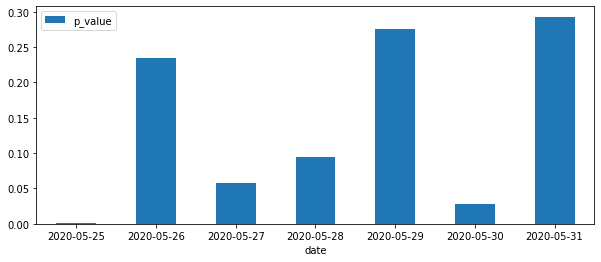

In [14]:
#df_stat_per_day.plot(kind='bar')
df_stat_per_day.plot.bar(x='date', y='p_value', rot=0, figsize=(10, 4))

In [ ]:
если смотреть подневное распределение p_value, то различия между группами менее явные, чем при проведении теста за весь период.